In [10]:
#   Dependencies
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

In [11]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [12]:
#   Python SQL toolkit and ORM
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [13]:
#   Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [14]:
#   reflect an existing database into a new model
Base = automap_base()

#   Reflect the tables
Base.prepare(autoload_with = engine)

In [15]:
#   View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [16]:
#   Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [17]:
#   Create session from Python to DB
session = Session(bind = engine)

# Exploratory Precipitation Analysis

In [18]:
#   Find the most recent date of the dataset

data, = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Print
print(data)

2017-08-23


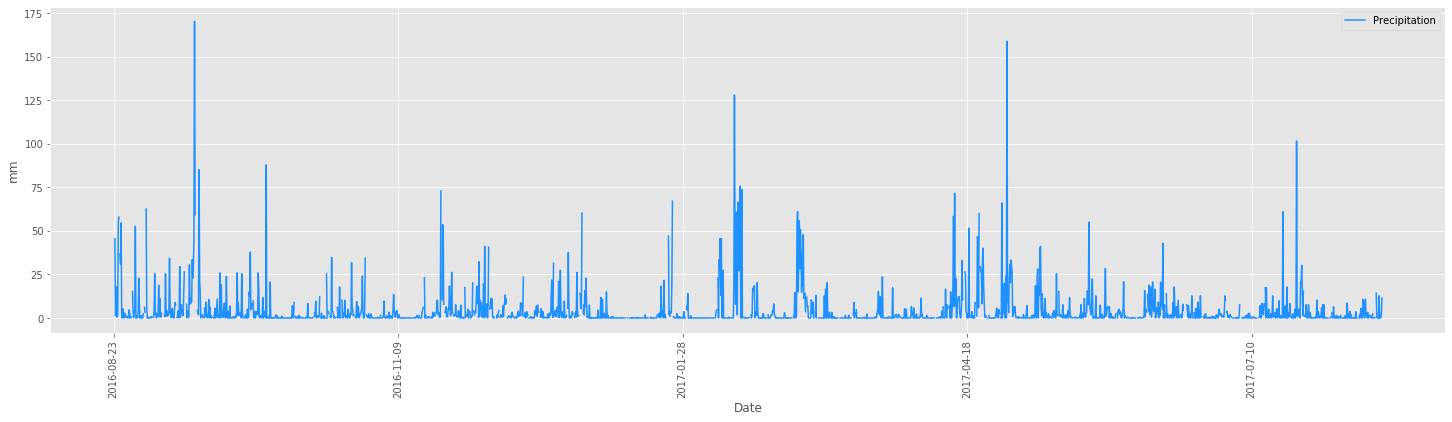

In [19]:
#   Design a query to retrieve the last 12 months of precipitation data and plot the results/
#   Starting from the most recent data point in the database.

#   Calculate the date one year from the last date in the dataset
data, = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

date = dt.datetime.strptime(data, "%Y-%m-%d").date() - dt.timedelta(365)

#   Perform a query to retrieve the data and precipitation scores

prcpquery = session.query(Measurement.date, Measurement.prcp)\
            .filter(Measurement.date >= date).all()

#   Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(prcpquery, columns = ["Date", "Precipitation"])
df = df.set_index("Date")

#   Sort the dataframe by date

df = df.sort_index(ascending= True)

#   Use Pandas Plotting with Matplotlib to plot the data
df.reset_index(inplace = True)
df_plot = df.plot.line(x = "Date", y = "Precipitation", c = "dodgerblue", rot = 90, figsize = (25,6))
df_plot.set_ylabel("mm")

plt.show()


In [162]:
#   Use Pandas to calculate the summary statistics for the precipitation data

print(f"Mean: {df['Precipitation'].mean()}")
print(f"Median: {df['Precipitation'].median()}")
print(f"Mode: {df['Precipitation'].mode().iloc[0]}")
print(f"Min: {df['Precipitation'].min()}")
print(f"Max: {df['Precipitation'].max()}")
print(f"Std. Dev: {df['Precipitation'].std()}")
print(f"Variance: {df['Precipitation'].var()}")

Mean: 4.4851116625310175
Median: 0.5
Mode: 0.0
Min: 0.0
Max: 170.2
Std. Dev: 11.690531509988574
Variance: 136.66852698603572


# Exploratory Station Analysis



In [163]:
#   Design a query to calculate the total number of stations in the dataset
session.query(Station.station).count()


9

In [164]:
#   Design a query to find the most active stations (the stations that have the most rows)
#   List the stations and the counts in descending order

# Columns to return
sel = [Station.name,
        Station.station,
        func.count(Measurement.station)]

# Store query into object for iteration
data =              session.query(*sel)                                 \
                    .filter(Station.station == Measurement.station)     \
                    .group_by(Station.station)                          \
                    .order_by(sel[2].desc()).all()

# Print results
for station in data:
    print(f"Station: {station[0]}| Count: {station[2]}")


Station: WAIHEE 837.5, HI US| Count: 2772
Station: WAIKIKI 717.2, HI US| Count: 2724
Station: KANEOHE 838.1, HI US| Count: 2709
Station: WAIMANALO EXPERIMENTAL FARM, HI US| Count: 2669
Station: MANOA LYON ARBO 785.2, HI US| Count: 2612
Station: KUALOA RANCH HEADQUARTERS 886.9, HI US| Count: 2202
Station: HONOLULU OBSERVATORY 702.2, HI US| Count: 1979
Station: PEARL CITY, HI US| Count: 1372
Station: UPPER WAHIAWA 874.3, HI US| Count: 511


In [165]:
#   Using the most active station id from the previous query, calculate the
#   lowest, highest, and average temperature

# Store latest station with data object from previous cell 
# (Station id was omitted in the printing, hence why the subscript is as such)
station = data[0][1]

# Columns to return
sel = [func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)]

# Store query
output = session.query(*sel).filter(Measurement.station == station).one()

# Print
print(f"Min: {output[0]}")
print(f"Max: {output[1]}")
print(f"Mean: {output[2]}")

Min: 12.2
Max: 29.4
Mean: 22.03582251082252


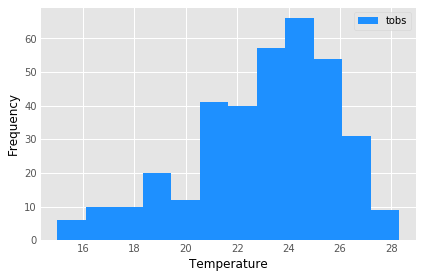

In [197]:
#   Using the most active station id,
#   Query the last 12 months of temperature observation data for this station and
#   plot the results in a histogram

#   Query last 12 months for the most active station

# Get latest date for station
data, = session.query(Measurement.date)\
        .filter(Measurement.station == station)\
        .order_by(Measurement.date.desc())\
        .first()

# Get date for one year ago
date = dt.datetime.strptime(data, "%Y-%m-%d") - dt.timedelta(365)


# Columns to return
sel = [Measurement.date, Measurement.tobs]

# Store query output for df creation
data = session.query(*sel)                     \
                    .filter(Measurement.station == station)     \
                    .filter(Measurement.date >= date)           \
                    .order_by(Measurement.tobs.desc()).all()

# Create df for plotting
df = pd.DataFrame(data, columns = ["Date", "Temperature"]).set_index("Date")

# Plot histogram
plt.hist(df["Temperature"], bins = 12, color = "dodgerblue", label = "tobs")
plt.xlabel("Temperature", c = "black")
plt.ylabel("Frequency", c = "black")
plt.legend(loc = 1)

plt.show()



# Close Session

In [198]:
#   Close session
session.close()